In [9]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from seaborn import heatmap

import lightgbm as lgb
import xgboost
from xgboost import XGBClassifier


In [11]:
X_train = pd.read_csv('X_train.csv', index_col='id')
y_train = pd.read_csv('y_train.csv', index_col='id')
# X_test = pd.read_csv('X_test.csv', index_col='id')

In [13]:
y = np.array(y_train).ravel()

In [14]:
# X is a DataFrame
def raw_to_normalized(X):
    X_normalized = [[] for _ in range(X.shape[0])]
    for i in range(X.shape[0]):
        X_normalized[i] = X.iloc[i].dropna().to_numpy()
        X_normalized[i] /= np.max(np.abs(X_normalized[i]))
    return X_normalized

In [16]:
X_train_normalized = raw_to_normalized(X_train)
# X_test_normalized = raw_to_normalized(X_test)

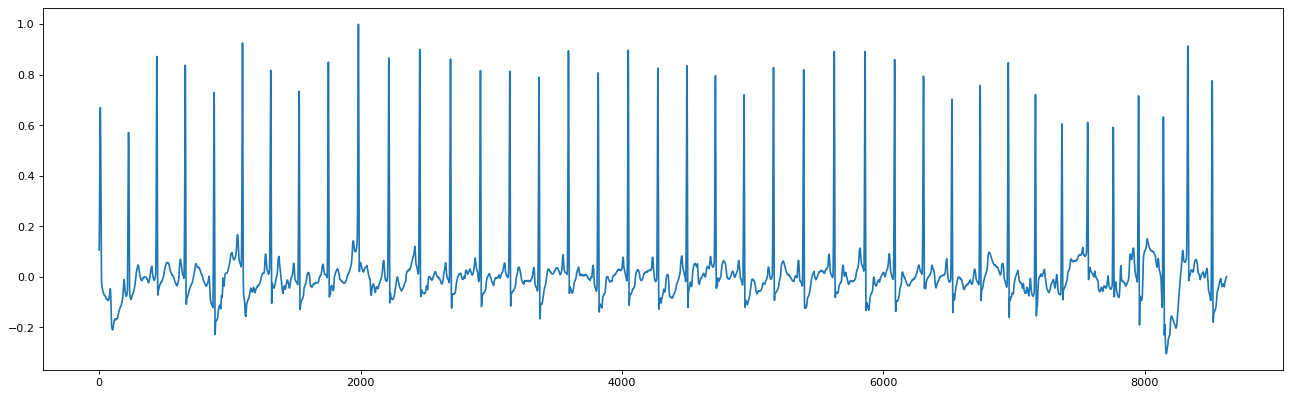

In [17]:
f = plt.figure(figsize=(20, 6), dpi=80)
plt.plot(X_train_normalized[484])

In [19]:
def feature_extraction(X):
    new_X = np.zeros((len(X), 10))
    for i in range(len(X)):
        signal = X[i]
        r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
        working = False
        beatTest = False
        if len(r_peaks) >= 2:
            beatTest = True
            diff = np.diff(r_peaks)
            beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
            if len(beats) > 0:
                working = True
                mu = np.mean(beats, axis=0) 
                var = np.std(beats, axis=0)
                new_X[i][0] = mu.max()
                new_X[i][1] = mu.min()               
                new_X[i][2] = var.mean()
                new_X[i][3] = diff.mean()
                new_X[i][4] = diff.std()
                new_X[i][5] = diff.max() - diff.min()
                new_X[i][6] = diff.max()
                new_X[i][7] = diff.min()
                new_X[i][8] = len(signal)
                new_X[i][9] = len(r_peaks)
        if not working:
            new_X[i][0] = signal.max()
            new_X[i][1] = signal.min()
            new_X[i][2] = signal.std() if len(signal) > 1 else 0
            new_X[i][3] = diff.mean() if beatTest else 0
            new_X[i][4] = diff.std() if beatTest else 0
            new_X[i][5] = diff.max() - diff.min() if beatTest else 0
            new_X[i][6] = diff.max() if beatTest else 0
            new_X[i][7] = diff.min() if beatTest else 0
            new_X[i][8] = len(signal)
            new_X[i][9] = len(r_peaks)

        if i % 500 == 0:
            print(i)
        
    return new_X

In [20]:
X_train_features = feature_extraction(X_train_normalized)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [22]:
# X_test_features = feature_extraction(X_test_normalized)

In [23]:
# X_train_sub_features = X_train_features[:,np.array([0,1,2,3,4])]
X_train_sub_features = X_train_features
# X_test_sub_features = X_test_features[:, np.array([0,1,2,3,4])]

In [24]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

In [25]:
# model = GradientBoostingClassifier(n_estimators=100)
# model = DecisionTreeClassifier(max_depth=6)
model = RandomForestClassifier(class_weight='balanced_subsample')
# model = RandomForestClassifier(class_weight='balanced')
# model = lgb.LGBMClassifier(class_weight='balanced')
# model = BaggingClassifier()
# model = EasyEnsembleClassifier()
# model = XGBClassifier(class_weight='balanced_subsample')

In [26]:
scores = cross_validate(model, X_train_features, y, scoring=scoring, cv=5)
scores

{'fit_time': array([0.70621562, 0.70049238, 0.71351194, 0.70395637, 0.70432138]),
 'score_time': array([0.01953173, 0.01936913, 0.01947021, 0.0193336 , 0.01935744]),
 'test_accuracy': array([0.734375  , 0.75390625, 0.75366569, 0.73509286, 0.72531769]),
 'test_precision': array([0.734375  , 0.75390625, 0.75366569, 0.73509286, 0.72531769]),
 'test_recall': array([0.734375  , 0.75390625, 0.75366569, 0.73509286, 0.72531769]),
 'test_f1_score': array([0.734375  , 0.75390625, 0.75366569, 0.73509286, 0.72531769])}

In [27]:
scores['test_f1_score'].mean()

0.7404714992668623

In [30]:
model.fit(X_train_features, y)

RandomForestClassifier(class_weight='balanced_subsample')

In [31]:
model.feature_importances_

array([0.11266141, 0.0921401 , 0.1173064 , 0.10290698, 0.13855501,
       0.09308459, 0.07667067, 0.12061984, 0.08318256, 0.06287243])

In [33]:
# ypred = model.predict(X_test)

In [35]:
# ytest_submission = pd.DataFrame(ypred, columns=['y'])

In [36]:
# ytest_submission.to_csv('submission.csv')

In [37]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train_features, y, test_size=0.33)

In [38]:
model.fit(X_train_train, y_train_train)

RandomForestClassifier(class_weight='balanced_subsample')

In [39]:
ytrainpred = model.predict(X_train_val)

In [ ]:
M = confusion_matrix(ytrainpred, y_train_val)
M

In [ ]:
M = normalize(M, norm='l1')
M

In [ ]:
heatmap(M, annot=True)

In [ ]:
Y_TO_SUBMIT = np.zeros(len(y))

## Step 1: Find Class 3.

In [ ]:
model = RandomForestClassifier(max_depth=10)

In [ ]:
y3 = 1* (y == 3)

In [ ]:
X_train_sub_3 = X_train_features

In [ ]:
scores = cross_validate(model, X_train_sub_3, y3, scoring=scoring, cv=5)
scores

In [ ]:
scores['test_f1_score'].mean()

In [ ]:
model.fit(X_train_features, y3)

In [ ]:
model.feature_importances_

In [ ]:
Y_PRED_3 = model.predict(X_test_features)

In [ ]:
Y_TO_SUBMIT[np.where(Y_PRED_3 == 1)] = 3

## Step 2: Find Class 1.

In [ ]:
X_train_sub_1 = X_train_features[:, np.array([3,4,5,6])]

In [ ]:
y1 = 1 * (y == 1)

In [ ]:
scores = cross_validate(RandomForestClassifier(max_depth=10), X_train_sub_1, y1, scoring=scoring, cv=5)
scores

In [ ]:
scores['test_f1_score'].mean()

In [ ]:
model.fit(X_train_features[:,np.array([3,4,5,6])], y1)

In [ ]:
model.feature_importances_

In [ ]:
Y_PRED_1 = model.predict(X_test_features[:,np.array([3,4,5,6])])

In [ ]:
Y_TO_SUBMIT[np.where(Y_PRED_1 == 1)] = 1

## Step 3: Find Class 2

In [ ]:
y2 = 1 * (y == 2)

In [ ]:
X_train_features_sub_2 = X_train_features

In [ ]:
scores = cross_validate(model, X_train_features_sub_2, y2, scoring=scoring, cv=5)
scores

In [ ]:
scores['test_f1_score'].mean()

In [ ]:
model.fit(X_train_features, y2)

In [ ]:
model.feature_importances_

In [ ]:
Y_PRED_2 = model.predict(X_test_features)

In [ ]:
Y_TO_SUBMIT[np.where(Y_PRED_2 == 1)] = 2

## Step 3: Find Class 0

In [ ]:
y0 = 1 * (y == 0)

In [ ]:
X_train_features_sub_0 = X_train_features

In [ ]:
scores = cross_validate(model, X_train_features_sub_0, y0, scoring=scoring, cv=5)
scores

In [ ]:
scores['test_f1_score'].mean()

In [ ]:
model.fit(X_train_features_sub_0, y0)

In [ ]:
model.feature_importances_

In [ ]:
Y_PRED_0 = model.predict(X_test_features)

In [ ]:
Y_TO_SUBMIT[np.where(Y_PRED_2 == 1)] = 0

## Step 4: Classify

In [ ]:
np.intersect1d(np.where(Y_PRED_0 == 1)[0], np.where(Y_PRED_2 == 1)[0])

In [ ]:
np.intersect1d(np.where(Y_PRED_1 == 1)[0], np.where(Y_PRED_2 == 1)[0])

In [ ]:
ytest_submission = pd.DataFrame(Y_TO_SUBMIT, columns=['y'])

In [ ]:
ytest_submission.to_csv('submission.csv')